In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np
%matplotlib inline

In [26]:
#used for text preprocessing.
import re

In [27]:
sentences = """Throughout my career, I have had the opportunity to work on a diverse range of mobile app projects. My proficiency in Flutter, along with my Android development skills, has allowed me to create user-friendly and high-performance applications. I take pride in my ability to transform creative concepts into functional, feature-rich apps that deliver exceptional user experiences."""

Clean Data

In [28]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

Vocabulary

In [29]:
words = sentences.split()
vocab = set(words)

In [30]:
vocab

{'ability',
 'allowed',
 'along',
 'and',
 'android',
 'app',
 'applications',
 'apps',
 'career',
 'concepts',
 'create',
 'creative',
 'deliver',
 'development',
 'diverse',
 'exceptional',
 'experiences',
 'feature',
 'flutter',
 'friendly',
 'functional',
 'had',
 'has',
 'have',
 'high',
 'in',
 'into',
 'me',
 'mobile',
 'my',
 'of',
 'on',
 'opportunity',
 'performance',
 'pride',
 'proficiency',
 'projects',
 'range',
 'rich',
 'skills',
 'take',
 'that',
 'the',
 'throughout',
 'to',
 'transform',
 'user',
 'with',
 'work'}

In [31]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

Implementation

In [32]:
#Dictionaries are created to map words to their corresponding indices (word_to_ix) and vice versa (ix_to_word).
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

Data bags

In [33]:
#The training data is prepared in the form of context-target pairs. For each word in the input text, a context of two words before and two words after is considered. The target word is the word at the current position. The first five data samples are printed.
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['throughout', 'my', 'have', 'had'], 'career'), (['my', 'career', 'had', 'the'], 'have'), (['career', 'have', 'the', 'opportunity'], 'had'), (['have', 'had', 'opportunity', 'to'], 'the'), (['had', 'the', 'to', 'work'], 'opportunity')]


Embeddings

In [34]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))

Linear Model

In [35]:
#This function performs a linear transformation. It takes an input m and a weight matrix theta, and computes the dot product of m and theta.
def linear(m, theta):
    w = theta
    return m.dot(w)

Log softmax + NLLloss = Cross Entropy

In [36]:
#This function calculates the logarithm of the softmax function. It takes a vector x as input, subtracts the maximum value to improve numerical stability, exponentiates each element, and then normalizes by the sum of exponentiated values.
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

In [37]:
#This function computes the negative log-likelihood loss. It takes two inputs: logs, which are the log probabilities predicted by the model, and targets, which are the true class labels. It calculates the negative log-likelihood for each example and returns the average.
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [38]:
#This function combines the calculation of the log-softmax and cross-entropy loss. It takes the logits (raw output from the model) and the target labels. It first creates a one-hot encoded matrix (out) for the target labels. Then, it computes the softmax probabilities and calculates the cross-entropy loss.
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- out + softmax) / logits.shape[0]

Forward function

In [39]:
#This function represents the forward pass of the neural network. It takes the indices of the context words (context_idxs) and the model parameters (theta). It performs the following steps:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)

    return m, n, o

Backward function

In [40]:
#Computes the gradient of the loss with respect to the log-softmax output (dlog).
#Computes the gradient of the loss with respect to the model parameters (dw) by multiplying the transposed m with dlog.
#Returns the gradient with respect to the model parameters.
def backward(preds, theta, target_idxs):
    m, n, o = preds

    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)

    return dw

Optimize function

In [41]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

Training

In [42]:
#This line initializes the model parameters (theta) with random values drawn from a uniform distribution between -1 and 1. The shape of theta is determined by the product of the context size, embedding dimension, and vocabulary size.
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [43]:
#It then runs a training loop for 80 epochs, updating the model parameters (theta) based on the negative log-likelihood loss.
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)


    epoch_losses[epoch] = losses

Analyze

Plot loss/epoch

Text(0, 0.5, 'Losses')

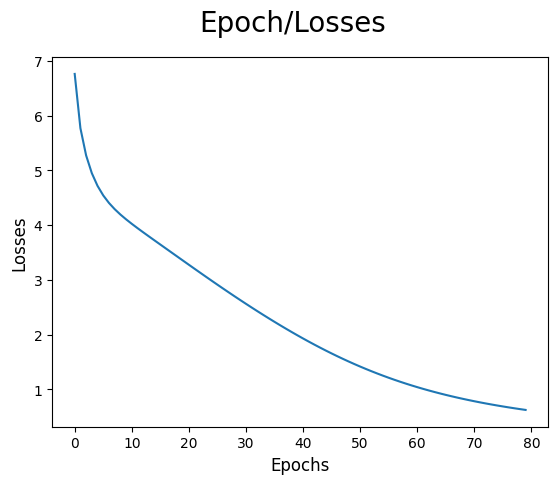

In [44]:
#This block visualizes the loss values across epochs using Matplotlib.
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

Predict function

In [45]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]

    return word

In [46]:

predict(['transform','creative','into','functional' ])

'concepts'

Accuracy

In [47]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1

    return (1 - (wrong / len(data)))

In [48]:
accuracy()

1.0

In [49]:
predict(['opportunity','work','diverse','range' ])

'on'